# SAM2 Video Segmentation Experiment

In [1]:
from pathlib import Path
import os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import torch
from sam2.build_sam import build_sam2_video_predictor

CHECKPOINT = "./sam2_hiera_large.pt"
CONFIG = "sam2_hiera_l.yaml"
DEVICE = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")  # Use GPU if available

sam2_model = build_sam2_video_predictor(CONFIG, CHECKPOINT, device=DEVICE)

In [3]:
# Data Preparation: Convert png to JEPG
data_dir = Path('./snemi')
raw_image_pngs = data_dir / "image_pngs"
seg_pngs = data_dir / "seg_pngs"
raw_image_jpgs = data_dir / "image_jpgs"
seg_jpgs = data_dir / "seg_jpgs"
os.makedirs(raw_image_jpgs, exist_ok = True)
os.makedirs(seg_jpgs, exist_ok = True)

In [4]:
image_png_files =sorted( [raw_image_pngs / filename for filename in os.listdir(raw_image_pngs)])
seg_png_files = sorted([seg_pngs / filename for filename in os.listdir(seg_pngs)])
def convertpng2jpg(file_path, target_dir):
    img = Image.open(file_path)
    rbg_img = img.convert('RGB')
    file_name = file_path.stem 
    digits = int(file_name[-4:])
    target_path = target_dir / (f'{digits:05d}.jpeg')
    rbg_img.save(target_path, format='JPEG')
    return target_path
image_jpg_files = [convertpng2jpg(file_path, raw_image_jpgs) for file_path in image_png_files]
seg_png_files = [convertpng2jpg(file_path, seg_jpgs) for file_path in seg_png_files]

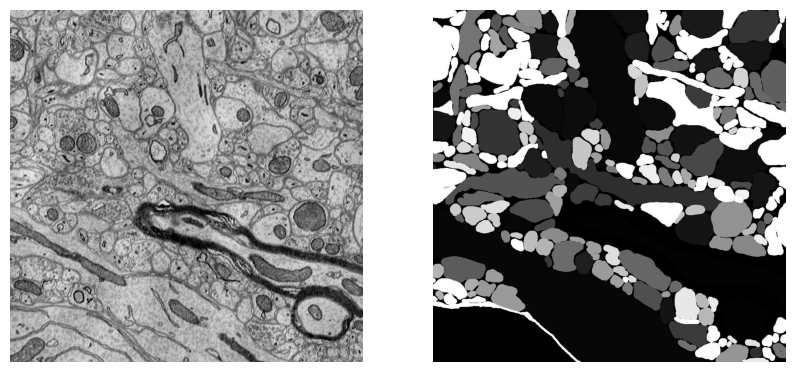

In [5]:
# - Verify the Converted Image
image0000 = Image.open(image_jpg_files[0])
seg0000 = Image.open(seg_png_files[0])

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].imshow(image0000)
axs[0].axis('off')

axs[1].imshow(seg0000)
axs[1].axis('off')

plt.show()


In [6]:
inference_state = sam2_model.init_state(str(raw_image_jpgs))

frame loading (JPEG): 100%|██████████| 100/100 [00:02<00:00, 43.97it/s]


In [7]:
# - visualize image and mask
def show_mask(mask, ax, obj_id=None, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        cmap = plt.get_cmap("tab10")
        cmap_idx = 0 if obj_id is None else obj_id
        color = np.array([*cmap(cmap_idx)[:3], 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)


def show_points(coords, labels, ax, marker_size=200):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)


def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))

/home/mitochondria/Desktop/yuxuan_exp/SAM2_finetuning/segment-anything-2/sam2/modeling/sam/transformer.py:270: UserWarning: Memory efficient kernel not used because: (Triggered internally at ../aten/src/ATen/native/transformers/cuda/sdp_utils.cpp:718.)
  out = F.scaled_dot_product_attention(q, k, v, dropout_p=dropout_p)
/home/mitochondria/Desktop/yuxuan_exp/SAM2_finetuning/segment-anything-2/sam2/modeling/sam/transformer.py:270: UserWarning: Memory Efficient attention has been runtime disabled. (Triggered internally at ../aten/src/ATen/native/transformers/sdp_utils_cpp.h:495.)
  out = F.scaled_dot_product_attention(q, k, v, dropout_p=dropout_p)
/home/mitochondria/Desktop/yuxuan_exp/SAM2_finetuning/segment-anything-2/sam2/modeling/sam/transformer.py:270: UserWarning: Flash attention kernel not used because: (Triggered internally at ../aten/src/ATen/native/transformers/cuda/sdp_utils.cpp:720.)
  out = F.scaled_dot_product_attention(q, k, v, dropout_p=dropout_p)
/home/mitochondria/Desktop

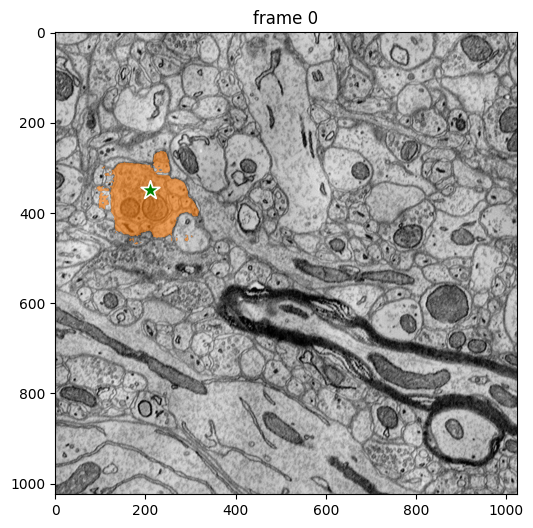

In [8]:
frame_names = image_jpg_files 
ann_frame_idx = 0  # the frame index we interact with
ann_obj_id = 1  # give a unique id to each object we interact with (it can be any integers)

# Let's add a positive click at (x, y) = (210, 350) to get started
points = np.array([[210, 350]], dtype=np.float32)
# for labels, `1` means positive click and `0` means negative click
labels = np.array([1], np.int32)
_, out_obj_ids, out_mask_logits = sam2_model.add_new_points_or_box(
    inference_state=inference_state,
    frame_idx=ann_frame_idx,
    obj_id=ann_obj_id,
    points=points,
    labels=labels,
)

# show the results on the current (interacted) frame
plt.figure(figsize=(9, 6))
plt.title(f"frame {ann_frame_idx}")
plt.imshow(Image.open(frame_names[ann_frame_idx]))
show_points(points, labels, plt.gca())
show_mask((out_mask_logits[0] > 0.0).cpu().numpy(), plt.gca(), obj_id=out_obj_ids[0])

propagate in video: 100%|██████████| 100/100 [00:29<00:00,  3.39it/s]


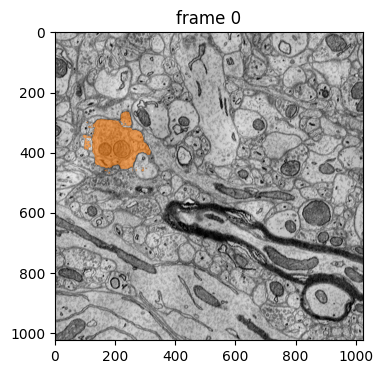

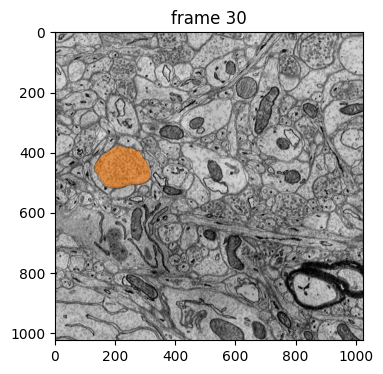

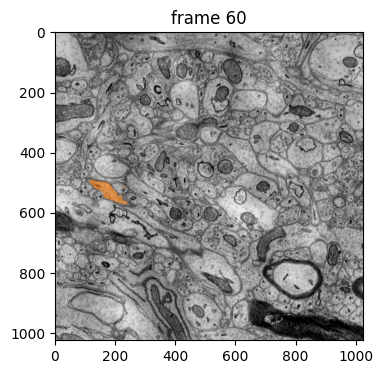

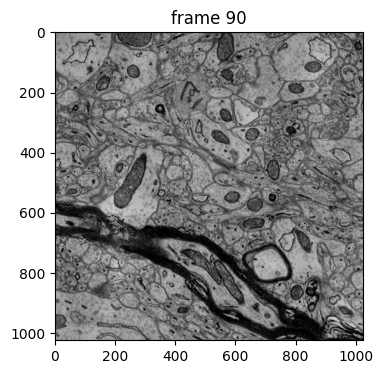

In [10]:
# run propagation throughout the video and collect the results in a dict
video_segments = {}  # video_segments contains the per-frame segmentation results
for out_frame_idx, out_obj_ids, out_mask_logits in sam2_model.propagate_in_video(inference_state):
    video_segments[out_frame_idx] = {
        out_obj_id: (out_mask_logits[i] > 0.0).cpu().numpy()
        for i, out_obj_id in enumerate(out_obj_ids)
    }
# render the segmentation results every few frames
vis_frame_stride = 30
plt.close("all")
for out_frame_idx in range(0, len(frame_names), vis_frame_stride):
    plt.figure(figsize=(6, 4))
    plt.title(f"frame {out_frame_idx}")
    plt.imshow(Image.open(frame_names[out_frame_idx]))
    for out_obj_id, out_mask in video_segments[out_frame_idx].items():
        show_mask(out_mask, plt.gca(), obj_id=out_obj_id)

In [39]:
# - Try add new mask to SAM2 
sam2_model.reset_state(inference_state)
frame_names = image_jpg_files 
ann_frame_idx = 0  # the frame index we interact with
ann_obj_id = 10  # give a unique id to each object we interact with (it can be any integers)

# Let's add a positive click at (x, y) = (210, 350) to get started
mask_image = Image.open(frame_names[ann_frame_idx])
masks = np.array(mask_image)[..., 0]
mask = np.zeros(masks.shape)
mask[masks == ann_obj_id] = ann_obj_id
# for labels, `1` means positive click and `0` means negative click
# labels = np.array([1], np.int32)
# _, out_obj_ids, out_mask_logits = sam2_model.add_new_points_or_box(
#     inference_state=inference_state,
#     frame_idx=ann_frame_idx,
#     obj_id=ann_obj_id,
#     points=points,
#     labels=labels,
# )

# # show the results on the current (interacted) frame
# plt.figure(figsize=(9, 6))
# plt.title(f"frame {ann_frame_idx}")
# plt.imshow(Image.open(frame_names[ann_frame_idx]))
# show_points(points, labels, plt.gca())
# show_mask((out_mask_logits[0] > 0.0).cpu().numpy(), plt.gca(), obj_id=out_obj_ids[0])

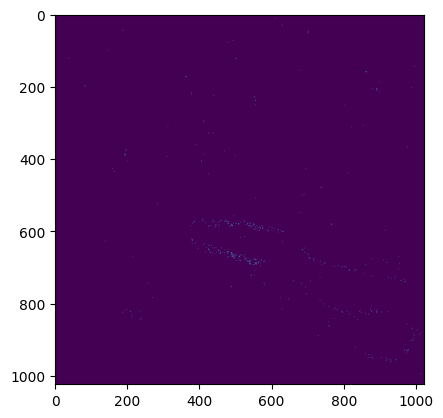

In [40]:
plt.imshow(mask)

/home/mitochondria/Desktop/yuxuan_exp/SAM2_finetuning/segment-anything-2/sam2/sam2_video_predictor.py:873: UserWarning: cannot import name '_C' from 'sam2' (/home/mitochondria/Desktop/yuxuan_exp/SAM2_finetuning/segment-anything-2/sam2/__init__.py)

Skipping the post-processing step due to the error above. You can still use SAM 2 and it's OK to ignore the error above, although some post-processing functionality may be limited (which doesn't affect the results in most cases; see https://github.com/facebookresearch/segment-anything-2/blob/main/INSTALL.md).
  pred_masks_gpu = fill_holes_in_mask_scores(


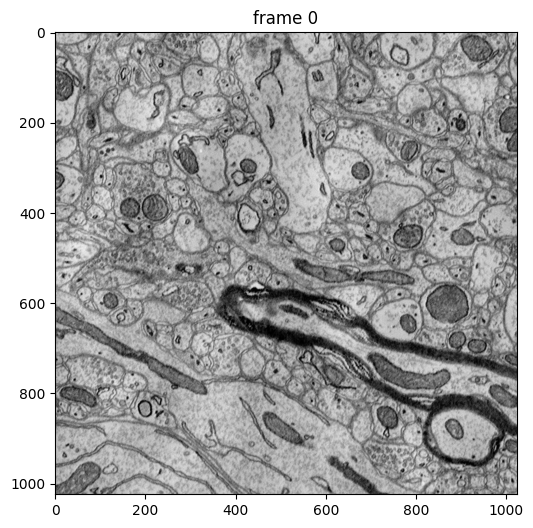

In [34]:
_, out_obj_ids, out_mask_logits = sam2_model.add_new_mask(
    inference_state = inference_state,
    frame_idx=ann_frame_idx,
    obj_id=ann_obj_id,
    mask = mask
)
# show the results on the current (interacted) frame
plt.figure(figsize=(9, 6))
plt.title(f"frame {ann_frame_idx}")
plt.imshow(Image.open(frame_names[ann_frame_idx]))
show_mask((out_mask_logits[0] > 0.0).cpu().numpy(), plt.gca(), obj_id=out_obj_ids[0])

In [22]:
cpu_out_logits_mask = out_mask_logits.cpu().numpy()
np.sum(cpu_out_logits_mask > 0)

0